<a href="https://colab.research.google.com/github/hansbrunner/epidemiology-analysis/blob/main/Framingham_Heart_Study/Framingham_Heart_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
The primary aim of this analysis is to explore the association between different risk factors (such as age, cholesterol, blood pressure, and smoking)
and the development of coronary heart disease (CHD).
I did not look at all variables in the dataset (see next notebook).
I found that age, systolic blood pressure, and being male show particularly strong associations with increased risk of CHD.
"""

In [103]:
import pandas as pd

# get data
df = pd.read_csv("framingham.csv")
print(df.head())

# Look at missing data
#print(df.info())
#print(df.isnull().sum())

# Impute or remove missing data
df = df.dropna()  # The simple way



   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2 

(3658, 16)

In [57]:
# Summarize key demographic variables: age, percentage smokers, cholesterol levels, BMI, blood pressure
continuous_columns = ["age","totChol","BMI","sysBP","diaBP"]
binary_columns = ["currentSmoker","male"]

# Calculate mean and standard deviation for continous data
summary_continuous = df[continuous_columns].agg(["mean", "std"])

# Calculate percentage for binary data
summary_binary = df[binary_columns].mean() * 100

# Create empty dataframe
summary_df = pd.DataFrame()

# Loop through continuous data and add mean and std
for col in continuous_columns:
    summary_df[f"{col}_mean"] = [summary_continuous.loc['mean', col]]
    summary_df[f"{col}_std"] = [summary_continuous.loc['std', col]]

# Add percentage of smokers
for col in binary_columns:
  summary_df[f"{col}_percentage"] = [summary_binary[col]]

# format the table for display
styled_summary = summary_df.style.format({
    **{f"{col}_mean": "{:.2f}" for col in continuous_columns},
    **{f"{col}_std": "± {:.2f}" for col in continuous_columns},
    **{f"{col}_percentage": "{:.2f}%" for col in binary_columns}
})

# Display the formatted table
styled_summary


,age_mean,age_std,totChol_mean,totChol_std,BMI_mean,BMI_std,sysBP_mean,sysBP_std,diaBP_mean,diaBP_std,currentSmoker_percentage,male_percentage
0,49.55,± 8.56,236.85,± 44.10,25.78,± 4.07,132.37,± 22.09,82.92,± 11.97,48.91%,44.37%


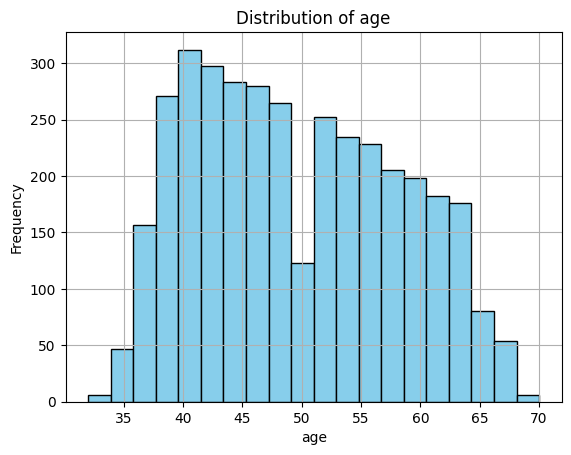

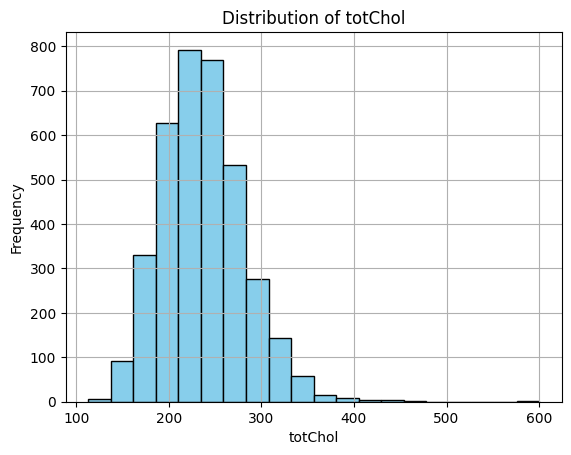

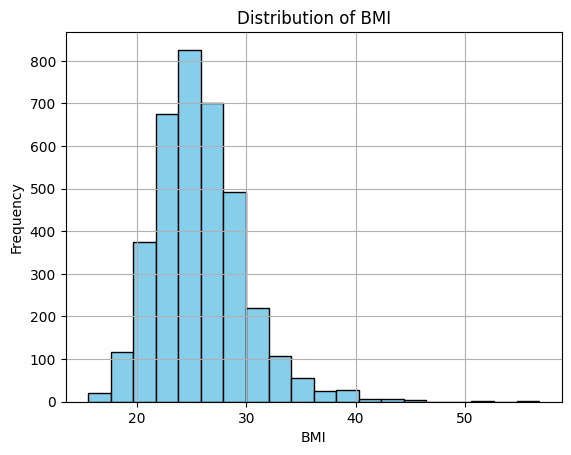

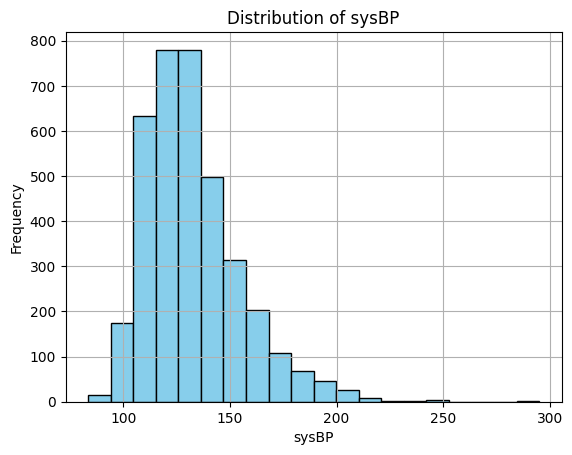

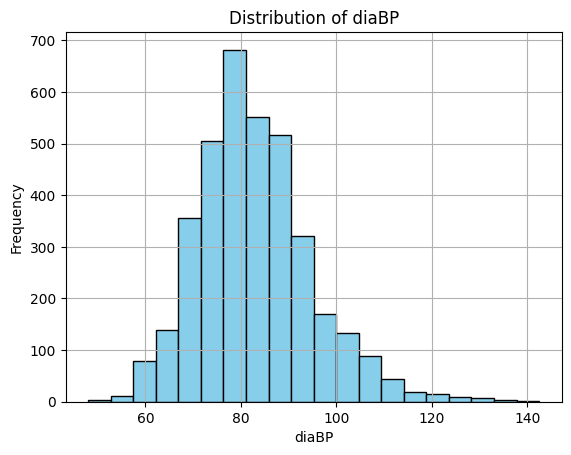

In [95]:
#Visualize distributions of key variables: age, cholesterol, blood pressure.
import matplotlib.pyplot as plt
import numpy as np

columns = ['age', 'totChol', 'BMI', 'sysBP', 'diaBP']

# Create histograms for continuous data
for col in columns:
    plt.figure()
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()



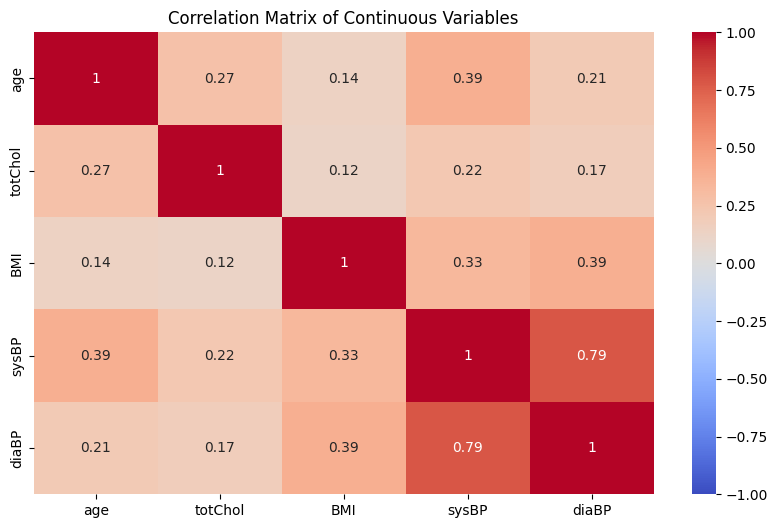

  Variable        VIF
0    const  93.166360
1      age   1.269000
2  totChol   1.099939
3      BMI   1.182301
4    sysBP   3.054141
5    diaBP   2.841581


In [59]:
#Examine multicollinearity.
import seaborn as sns

# Calculate the correlation matrix for the continuous variables
corr_matrix = df[['age', 'totChol', 'BMI', 'sysBP', 'diaBP']].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()
# Not surprinsingly is there are strong correlation between diastolic and systolic blood pressure.

# Alternatively Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant to the data
X = add_constant(df[['age', 'totChol', 'BMI', 'sysBP', 'diaBP']])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show the VIF results
print(vif)

# Multicollinearity is not a major concern (VIF less than 5)
# One could remove one of the blood pressure measures, or average to one variable.
# However, I will continue with both variables


In [64]:
# Risk factors for developing coronary heart disease (CHD) - binary variables (sex and current smoker)
# Contingency table, odds-ratio and Chi2 statistics
from scipy.stats import chi2_contingency

for col in binary_columns:
  tmp = df[[col,'TenYearCHD']]

  # Odds ratio
  table = pd.crosstab(tmp[col], tmp['TenYearCHD'], rownames=[col], colnames=['CHD'])
  a = table.iloc[0, 0]  # With cancer
  b = table.iloc[1, 0]  # With cancer
  c = table.iloc[0, 1]  # Without cancer
  d = table.iloc[1, 1]  # Without CHD
  odds_ratio = (a / c) / (b / d)
  #print(table)
  print(col)
  print(f'Odds Ratio: {odds_ratio}')

  chi2, p, dof, expected = chi2_contingency(table)
  print(f'Chi\u00B2: {chi2}, p-value: {p}')




currentSmoker
Odds Ratio: 1.1125845783792239
Chi²: 1.2389725931725915, p-value: 0.2656691520743377
male
Odds Ratio: 1.6656382978723403
Chi²: 30.24039576227628, p-value: 3.816765643320501e-08


In [84]:
# Risk factors for developing coronary heart disease (CHD) - continuous variables (age, cholesterol, blood pressure)
# Logistic regression and odds-ratio
import statsmodels.api as sm

# Univariate logistic regression for each predictor
y = df['TenYearCHD']  # Outcome variable
for col in continuous_columns:
  X = df[col]
  X = sm.add_constant(X)

  # Logistic regression
  model = sm.Logit(y, X)
  result = model.fit(disp=0)

  odds_ratios = np.exp(result.params)
  p_values = result.pvalues

  # Print
  print("\nOdds Ratios:")
  print(odds_ratios)
  print("P-Values:")
  print(p_values)





Odds Ratios:
const    0.003280
age      1.080834
dtype: float64
P-Values:
const    4.320709e-77
age      2.545342e-42
dtype: float64

Odds Ratios:
const      0.047699
totChol    1.005527
dtype: float64
P-Values:
const      4.785509e-34
totChol    4.352725e-08
dtype: float64

Odds Ratios:
const    0.045544
BMI      1.054007
dtype: float64
P-Values:
const    2.781731e-27
BMI      8.372041e-07
dtype: float64

Odds Ratios:
const    0.006218
sysBP    1.024954
dtype: float64
P-Values:
const    5.754886e-76
sysBP    4.106611e-37
dtype: float64

Odds Ratios:
const    0.011406
diaBP    1.033148
dtype: float64
P-Values:
const    9.576232e-45
diaBP    5.476571e-19
dtype: float64


In [96]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def choose_statistical_test(data1, data2):
    """
    Function to test for normality and equal variances, and choose the appropriate statistical test.

    Parameters:
    data1 (array-like): Data from group 1 (e.g., no CHD).
    data2 (array-like): Data from group 2 (e.g., CHD).

    Returns:
    result: Dictionary with the chosen test name, p-value, and other test results.
    """

    result = {}  # Dictionary to store the test result

    # Test for normality (Shapiro-Wilk test)
    stat1, p_norm1 = shapiro(data1)
    stat2, p_norm2 = shapiro(data2)

    # Check for normal distribution
    result['p_value_normality_group1'] = p_norm1
    result['p_value_normality_group2'] = p_norm2

    # If p-value < 0.05, data is not normally distributed
    normality_group1 = p_norm1 > 0.05
    normality_group2 = p_norm2 > 0.05

    # Test for equal variances (Levene's test)
    stat_var, p_var = levene(data1, data2)
    result['p_value_variance'] = p_var

    equal_variance = p_var > 0.05  # True if variances are equal (Levene's p > 0.05)

    # Choose appropriate test

    # Assume normally distribution (Central Limit Theory)
    if equal_variance:
        # If variances are equal, use standard t-test
        t_stat, p_value = ttest_ind(data1, data2, equal_var=True)
        result['test'] = 't-test (equal variances)'
    else:
        # If variances are not equal, use Welch's t-test
        t_stat, p_value = ttest_ind(data1, data2, equal_var=False)
        result['test'] = 'Welch\'s t-test (unequal variances)'

    result['stat'] = t_stat
    result['p_value'] = p_value

    #else:
        # If data is not normally distributed, use Mann-Whitney U test
     #   u_stat, p_value = mannwhitneyu(data1, data2)
     #   result['test'] = 'Mann-Whitney U test (non-parametric)'
     #   result['stat'] = u_stat
     #   result['p_value'] = p_value

    return result


{'p_value_normality_group1': 2.6204327584704426e-27, 'p_value_normality_group2': 7.645507426883393e-09, 'p_value_variance': 0.06895485368625257, 'test': 't-test (equal variances)', 'stat': -14.551681974696823, 'p_value': 1.1227010347053238e-46}
{'p_value_normality_group1': 7.324387714507976e-17, 'p_value_normality_group2': 7.178273002037201e-14, 'p_value_variance': 0.11573552032157473, 'test': 't-test (equal variances)', 'stat': -5.5459254975088355, 'p_value': 3.1312333433456134e-08}
{'p_value_normality_group1': 4.176327968043926e-28, 'p_value_normality_group2': 4.8635981561997035e-14, 'p_value_variance': 0.01497320793126383, 'test': "Welch's t-test (unequal variances)", 'stat': -4.553098529059457, 'p_value': 6.20744479965387e-06}
{'p_value_normality_group1': 1.7641929414258647e-33, 'p_value_normality_group2': 1.4513820864734713e-12, 'p_value_variance': 2.352116717706496e-16, 'test': "Welch's t-test (unequal variances)", 'stat': -11.41406603108955, 'p_value': 1.0284180833876892e-27}
{'

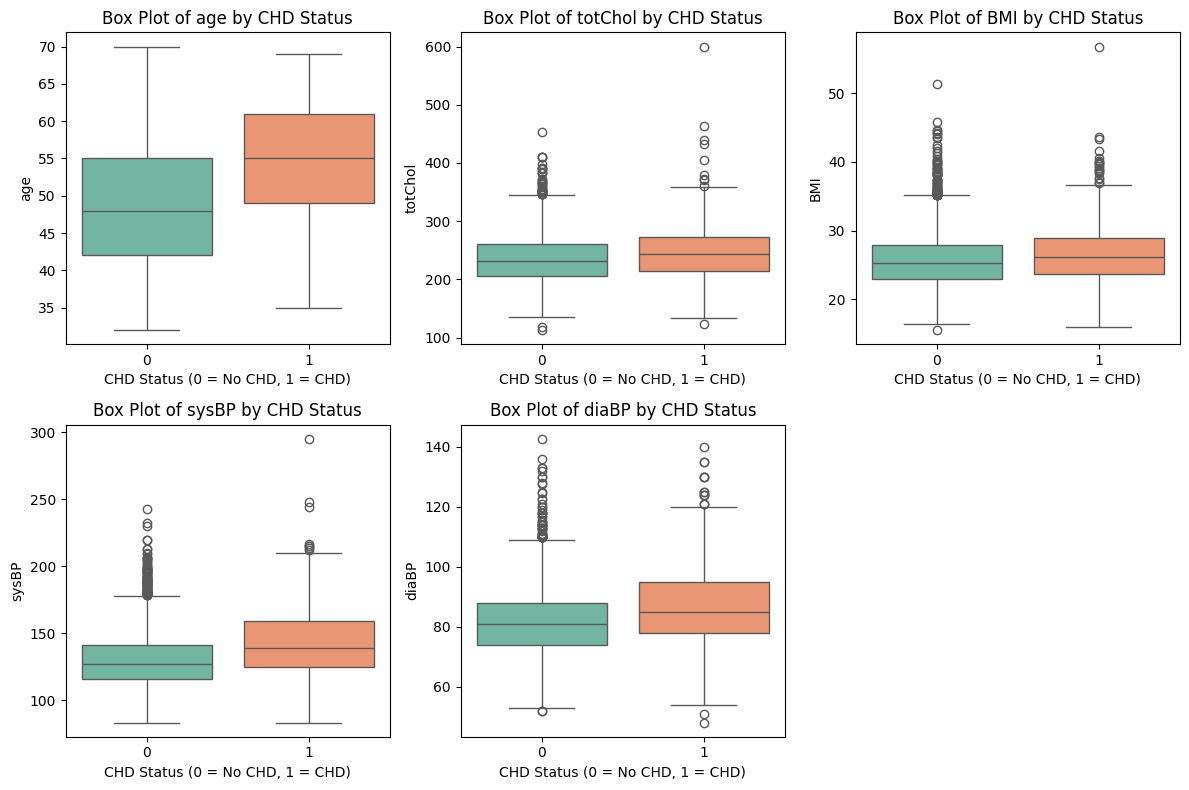

In [97]:
# Risk factors for continuous variables
# Box plots
from scipy.stats import shapiro
from scipy.stats import levene

# Create a figure with subplots for each variable
plt.figure(figsize=(12, 8))

# Loop through each variable and create a box plot
for i, var in enumerate(continuous_columns,1):
    plt.subplot(2, 3, i)  # Create a 2x2 grid of plots
    sns.boxplot(x='TenYearCHD', y=var, data=df, palette='Set2', hue='TenYearCHD')
    plt.title(f'Box Plot of {var} by CHD Status')
    plt.xlabel('CHD Status (0 = No CHD, 1 = CHD)')
    plt.ylabel(var)
    plt.legend().remove()
    # Statistical test
    results = choose_statistical_test(df[df['TenYearCHD'] == 0][var], df[df['TenYearCHD'] == 1][var] )
    print(results)

plt.tight_layout()
plt.show()

In [100]:
# Multivariate logistic regression to study risk factors (The ones I have chosen previously, see project for all variables)
# for developing CHD. A major concern for logistic regression is the multicollinearity and unbalanced data (CHD in approx 15% )
from sklearn.preprocessing import StandardScaler

# Normalized continuous variables
model_df = df.copy()
model_df[continuous_columns] = StandardScaler().fit_transform(model_df[continuous_columns])

X = model_df[continuous_columns+binary_columns]

# Add the constant term (intercept)
X = sm.add_constant(X)

# Dependent variable (binary outcome: CHD or no CHD)
y = model_df['TenYearCHD']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the regression model
print(result.summary())

# Calculate odds ratios (exp(coefficient))
odds_ratios = np.exp(result.params)
print("\nOdds Ratios:\n", odds_ratios)

Optimization terminated successfully.
         Current function value: 0.381005
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3658
Model:                          Logit   Df Residuals:                     3650
Method:                           MLE   Df Model:                            7
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.1069
Time:                        11:51:47   Log-Likelihood:                -1393.7
converged:                       True   LL-Null:                       -1560.6
Covariance Type:            nonrobust   LLR p-value:                 3.684e-68
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4383      0.092    -26.454      0.000      -2.619      -2.258
age               0.